# Uncertainty Quantification using Image Matching - Cylinder

## Description

Based on paper and source code:
 - Sciacchitano, A., Wieneke, B., & Scarano, F. (2013). PIV uncertainty quantification by image matching. *Measurement Science and Technology*, 24 (4). https://doi.org/10.1088/0957-0233/24/4/045302. 
 - http://piv.de/uncertainty/?page_id=221
 
**Step 1: Particle peak detection**

As described by (Sciacchitano et al., 2013, Eq. 1), the image intensity product $\Pi$ from image matching intensities is defined as:
$$
\Pi = \hat{I}_1\hat{I}_2
$$
The peaks image $\varphi$ is defined as:
$$
\varphi(i,j) = \begin{cases}
1\quad\text{if }\Pi(i,j)\text{ is a relative maximum} \\
0\quad\text{otherwise}
\end{cases}
$$

**Step 2: Disparity vector computation**

The sub-pixel peak position estimator adopted here is the standard 3-point Gaussian fit. The particle positions of times $t_1$ and $t_2$ are 
defined as $\boldsymbol{X}^1 = \{x^1_1,x^1_2,...,x^1_N\}$ and $\boldsymbol{X}^2 = \{x^2_1,x^2_2,...,x^2_N\}$. Discrete disparity vectors are defined as:
$$
\boldsymbol{D} = \{\boldsymbol{d}_1, \boldsymbol{d}_2,...,\boldsymbol{d}_N\} = \boldsymbol{X}^2 - \boldsymbol{X}^1
$$

**Step 3: Disparity ensemble statistics inside window**

The mean of disparity set inside a window is defined as:
$$
\mu = \frac{1}{N}\sum_{i\in N} c_i d_i
$$
where $c_i = \sqrt{\Pi(x_i)}$ for $i=1,2,...,N$. 

The standard deviation of disparity set inside a window is defined as:
$$
\sigma = \sqrt{\frac{\sum_{i\in N}c_i (d_i - \mu)^2}{\sum_{i\in N}c_i}}
$$

Finally, the instantaneous error (estimate) vector is defined as:
$$
\hat{\boldsymbol{\delta}} = \{\hat{\delta}_u,\hat{\delta}_v\} = \sqrt{\boldsymbol{\mu}^2 + \left(\frac{\boldsymbol{\sigma}}{\sqrt{N}}\right)^2}
$$



## Setup

**Packages**

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import pivuq

**Load images**

In [3]:
parent_path = "./data/cylinder_wake/"
image_pair = np.array(
    [plt.imread(os.path.join(parent_path + ipath)).astype("float") for ipath in ["frameA.tif", "frameB.tif"]]
)

**Load reference velocity**

In [4]:
data = np.load(os.path.join(parent_path + "vectors_OF.npz"))

X_ref = data["X"]
Y_ref = data["Y"]
U_ref = data["U"]

## Uncertainity quantificiation using image matching

**Method: ILK**

In [5]:
%%time

X_ilk, Y_ilk, D = pivuq.disparity.ilk(
    image_pair,
    U_ref,
    window_size=16,
    window="gaussian",
    velocity_upsample_kind="linear",
    warp_direction="center",
    warp_order=-1,
    warp_nsteps=1,
)

CPU times: user 8.57 s, sys: 126 ms, total: 8.7 s
Wall time: 7.71 s


**Method: SWS**

In [6]:
%%time
X_sws, Y_sws, delta, N, mu, sigma = pivuq.disparity.sws(
    image_pair,
    U_ref,
    window_size=16,
    window="gaussian",
    radius=1,
    sliding_window_subtraction=True,
    ROI=None,
    velocity_upsample_kind="linear",
    warp_direction="center",
    warp_order=-1,
    warp_nsteps=1,
)

CPU times: user 15.1 s, sys: 18.6 ms, total: 15.1 s
Wall time: 4.38 s


## Plot: Instantaneous error map

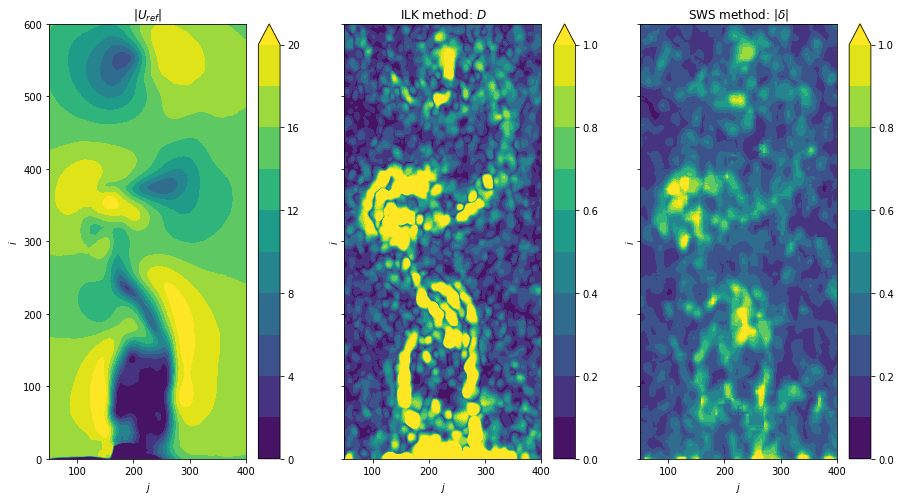

In [7]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 8))

# References velocity
ax = axes[0]
im = ax.contourf(X_ref, Y_ref, np.linalg.norm(U_ref, axis=0), np.linspace(0, 20, 11), extend="max")
fig.colorbar(im, ax=ax)
ax.set(title="$|U_{ref}|$")

# Uncertainty: ILK
ax = axes[1]
im = ax.contourf(X_ilk, Y_ilk, np.linalg.norm(D, axis=0), np.linspace(0, 1, 11), extend="max")
fig.colorbar(im, ax=ax)
ax.set(title="ILK method: $D$")

# Uncertainty: SWS
ax = axes[2]
im = ax.contourf(X_sws, Y_sws, np.linalg.norm(delta, axis=0), np.linspace(0, 1, 11), extend="max")
fig.colorbar(im, ax=ax)
ax.set(title="SWS method: $|\delta|$")

for ax in axes.ravel():
    ax.set(xlim=(50, 400), ylim=(0, 600), xlabel="$j$", ylabel="$i$")